In [102]:
import pandas as pd 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.impute import KNNImputer
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold , cross_val_score, learning_curve

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

import warnings
warnings.filterwarnings("ignore")                

In [112]:
# Dictionnaire.
# Key : Nom des models
# Values : models
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Support Vector Machine': SVR()
}

# Dictionnaire contenant le nom des models avec leurs paramètres.
param_grid = {
    'Ridge': {
        'alpha': [0.1, 1.0, 10.0],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    },
    'Lasso': {
        'alpha': [0.1, 1.0, 10.0],
        'max_iter': [1000, 2000, 3000],
        'selection': ['cyclic', 'random']
    },
    'Linear Regression': {
        'fit_intercept': [True, False],
        'copy_X': [True, False]
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    },
    'Support Vector Machine': {
        'C': [0.1, 1.0, 10.0],
        'kernel': ['linear', 'rbf', 'poly'],
        'epsilon': [0.1, 0.2, 0.5]
    }
}

In [104]:
# Import de la Data.
data = pd.read_csv("data/Housing_Price.csv")

In [105]:
# Fonction permettent de faire une learning curve.
def plot_learning_curve (model, jeu_entrainement, target_entrainement, model_name):
    
    # Génération de la courbe d'apprentissage
    train_sizes, train_scores, test_scores = learning_curve(model, jeu_entrainement, target_entrainement, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

    # Calcul des scores moyens et des écarts types pour les ensembles d'entraînement et de test
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)

    # Tracé de la courbe d'apprentissage avec redimensionnement de la figure
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(f"Courbe d'apprentissage {model_name}")
    ax.set_xlabel("Taille de l'ensemble d'entraînement")
    ax.set_ylabel("Score")
    ax.grid()
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validation croisée")
    ax.legend(loc="best")
    plt.show()

In [106]:
# 1) Supression de la colonne gender.
# 2) Remplaçement des "no" par des "nan" pour faciliter l'imputation.
# 3) Encodage de la variable catégorielle "ocean_proximity"
# 4) bool : imputation des données.
def preprocessing(data, imputing:bool):
    
    # Nettoyage : Encodage, conversion des colonnes.     
    if "gender" in data.columns:
        data.drop("gender", axis=1,inplace=True)
    if "households" in data.columns:
        data['households'].replace("no", np.nan , inplace=True)
        data["households"] = data["households"].astype('float64')
    if "ocean_proximity" in data.columns:
        data = pd.get_dummies(data, columns=['ocean_proximity'], prefix=[""])
    
    # Imputing des données.     
    if imputing:
        knn_imputer = KNNImputer(n_neighbors=2)  
        imputed_data = knn_imputer.fit_transform(data)
        imputed_df = pd.DataFrame(imputed_data, columns=data.columns)
        
        # On retourne le Dataframe avec données manquantes imputées.         
        return imputed_df
    
    # On retourne le Dataframe avec données manquantes non imputées.         
    return data

In [107]:
# 1) Réalisation d'un GridSearch à partir des dictionnaires définis plus haut.
def grid_search_regression(X, y, models_dict:dict):
    
    # Dictionnaires pour enregistrer les meilleurs models et les meilleurs paramètres.     
    best_models = {}
    best_params = {}
    
    # Exécution des models avec les paramètres.
    for model_name, model in models.items():
        grid_search = GridSearchCV(model, param_grid[model_name], cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X, y)
        best_models[model_name] = grid_search.best_estimator_
        best_params[model_name] = grid_search.best_params_
    
    # On retourne les meilleurs model & les meilleurs paramètres de chaque model.     
    return best_models, best_params

In [108]:
# 1) Séparation des données X et Y.
# 2) bool : Scaling des données.
# 3) TrainTestSplit des données.
# 4) bool : GridSearch.
# 5) bool : LearningCurve.
def model(preprocess_data, gridsearching:bool, scaling:bool, learning_curve, param_grid_dict:dict, models_dict:dict, target:str):
    
    
    # --------------  Scaling & TraintTestSplit --------------- #
    #===========================================================>    
    
    # Séparation X et Y.
    X = preprocess_data.drop(target, axis=1)
    Y = preprocess_data[target]
    
    # bool : Scaling des données.     
    if scaling:
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)

    # Modeling : Régression Linéaire.
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # --------------  Modeling whit GridSearch --------------- #
    #===========================================================>     
    
    # GridSearch.     
    if gridsearching:
        best_models, best_params = grid_search_regression(X_train, Y_train, models_dict)
        score_models_with_gridsearch = {}
        
        # liste contenant les scores RMSE de chaque modèles.
        rmse_values=[]
        
        # Entrainement et prédictions pour chaque modèles. 
        for model_name, model in best_models.items():
            y_pred = model.predict(X_test)
            score = r2_score(Y_test, y_pred)
            score_models_with_gridsearch[model_name] = score
            
            # Calcul du RMSE.          
            rmse = sqrt(mean_squared_error(Y_test, y_pred))
            rmse_values.append(rmse)
            
            # LearningCurve         
            if learning_curve:
                plot_learning_curve(model=model, jeu_entrainement=X_train, target_entrainement=Y_train, model_name=model_name)
        
        # Enregistrement des scores (R2) pour chaque modèles.         
        results_list = []
        for model_name, score in score_models_with_gridsearch.items():
            results_list.append({
                "Modèle"   : model_name,
                "Score R2" : score
            })
        
        # Création d'un DataFrame contenant les scores & nom de chaque model.         
        results_df = pd.DataFrame(results_list)
        
        # Ajout de la colonne 'Meilleurs Paramètres' avec le dictionnaire best_params.
        results_df = results_df.assign(**{"Meilleurs Paramètres": best_params.values()})
        results_df.insert(loc=2, column='RMSE', value=rmse_values)
        return results_df
    
    # ------------  Modeling whitout GridSearch -------------- #
    #===========================================================> 
    
    # dictionnaire withs scores & name models.     
    score_models_without_gridsearch = {}
    
    # liste contenant les scores RMSE de chaque modèles.
    rmse_values=[]
    
    # Entrainement et prédictions pour chaque modèles.         
    for model in models_dict.values():
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)
        score = r2_score(Y_test, y_pred)
        score_models_without_gridsearch[type(model).__name__] = score
        
        # Calcul du RMSE.          
        rmse = sqrt(mean_squared_error(Y_test, y_pred))
        rmse_values.append(rmse)
        
        # LearningCurve         
        if learning_curve:
            plot_learning_curve(model=model, jeu_entrainement=X_train, target_entrainement=Y_train, model_name=model)
    
    results_df = pd.DataFrame.from_dict(score_models_without_gridsearch, orient='index', columns=['R2 Score'])
    results_df ["RMSE"] = rmse_values
    return results_df

In [109]:
# 1) Preprocessing.
preprocess_data = preprocessing(
    data     = data,
    imputing = True
)

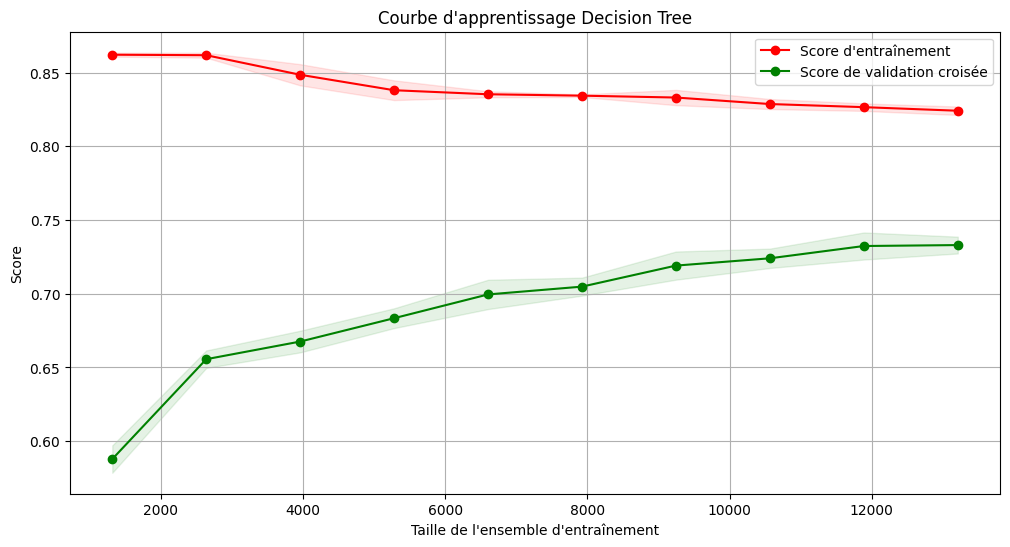

In [110]:
# 2) Modeling.
results_df = model(
    preprocess_data = preprocess_data, 
    gridsearching   = True,
    scaling         = False,
    learning_curve  = True,
    param_grid_dict = param_grid, 
    models_dict     = models,
    target          = "median_house_value"
)

In [111]:
# Affichaqe des résultats.
results_df

,Modèle,Score R2,RMSE,Meilleurs Paramètres
0,Decision Tree,0.730091,59471.943341,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_..."
